In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [35]:
# Plot manipulations
plt.rc('figure', figsize=(13,7))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

In [36]:
import env

## Acquisition w/ SQL server

In [8]:
query = '''
SELECT  logs.*,
        cohorts.name AS cohort,
        cohorts.start_date AS start,
        cohorts.end_date AS end
        
FROM logs
LEFT JOIN cohorts ON logs.cohort_id = cohorts.id

'''

In [9]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
df = pd.read_sql(query , url)

In [10]:
df.head()

,date,time,path,user_id,cohort_id,ip,cohort,start,end
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
 6   cohort     847330 non-null  object 
 7   start      847330 non-null  object 
 8   end        847330 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 61.8+ MB


In [12]:
## Managed to successfully grab the data we want, to include cohort name and that cohort's start/end times

## Preparing the data

In [14]:
# Setting datetime to index using df.date
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [17]:
pages = df['path'].resample('d').count()

In [22]:
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

In [25]:
df.index.min()

Timestamp('2018-01-26 00:00:00')

In [26]:
df.index.max()

Timestamp('2021-04-21 00:00:00')

<AxesSubplot:xlabel='date'>

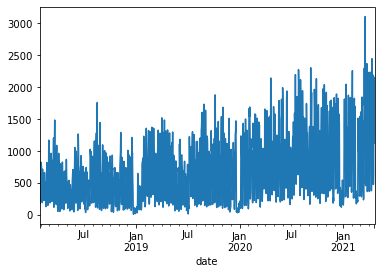

In [27]:
pages.plot()

In [28]:
# I believe (?) the above is finding the number of unique pages that are accessed by day.

#### Exponential Moving Averages

In [29]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()

In [30]:
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
# 30 day
ema_30d = pages.ewm(span=30).mean()
# 90 day
ema_90d = pages.ewm(span=90).mean()

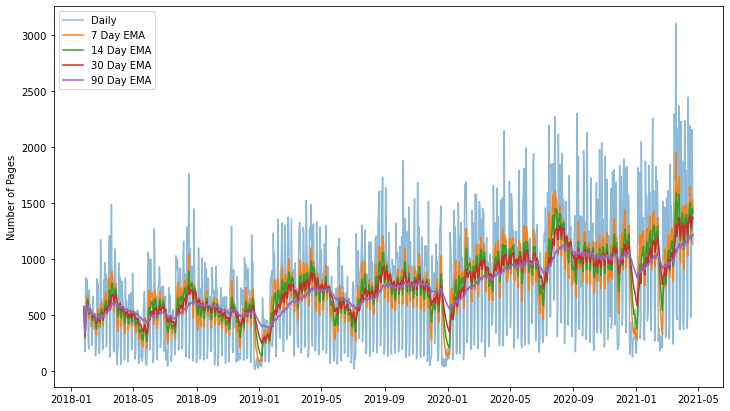

In [33]:
# Graphing the above EMAs
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7 Day EMA')
ax.plot(pages.index, ema_14d, label = '14 Day EMA')
ax.plot(pages.index, ema_30d, label = '30 Day EMA')
ax.plot(pages.index, ema_90d, label = '90 Day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of Pages')
plt.show()


### Bollinger Bands and %b

Bollinger Bands 
- volatility indicator and commonly used in stock market trading
- made up of 3 lines, upper band, lower band, midband

- %b acts as a z-score 
- %b = last - LB/ UB - LB
- if > 1, data point lies above the upper band
- if < 0, data point lies below the lower band
- if == .5, data point lies on the midband

In [37]:
# Setting the span of time
span = 30

In [38]:
# Computing midband
midband = pages.ewm(span=span).mean()
# Computing exponential stdev
stdev = pages.ewm(span=span).std()

In [39]:
# Creating upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [40]:
# Combine up and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']

In [41]:
new_df = pd.concat([pages, midband, bb], axis=1)
new_df.columns = ['pages', 'midband', 'ub', 'lb']

In [42]:
new_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


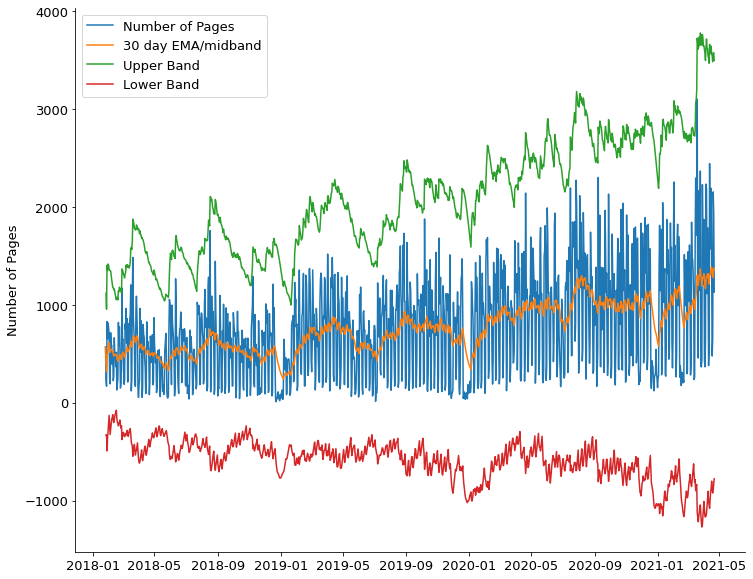

In [43]:
# Plot the bands
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(new_df.index, new_df.pages, label='Number of Pages')
ax.plot(new_df.index, new_df.midband, label='30 day EMA/midband')
ax.plot(new_df.index, new_df.ub, label='Upper Band')
ax.plot(new_df.index, new_df.lb, label='Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of Pages')

plt.show()

In [44]:
# Compute %b
# last - LB / UB - LB

In [45]:
# Last measure
last_measure = new_df.iloc[-1].pages
last_measure

1131.0

In [47]:
# Get lower band value on last date
last_lb = new_df.iloc[-1].lb
last_lb

-777.340451135389

In [48]:
# Get upper band value on last date
last_ub = new_df.iloc[-1].ub
last_ub

3499.0943598250406

In [49]:
# Compute %b
last_pct_b = (last_measure - last_lb) / (last_ub - last_lb)
print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.45


In [50]:
# Computing for each point
new_df['pct_b'] = (new_df['pages'] - new_df['lb']) / (new_df['ub'] - new_df['lb'])
new_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


### Searching for anomalies

In [52]:
new_df[new_df['pct_b'] > 1]

,pages,midband,ub,lb,pct_b
date,,,,,


### Series of Functions

In [55]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [56]:
# Test on single user
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

In [58]:
# Loop through all users
span = 30
weight = 3.5
anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
             user_df = find_anomalies(df, u, span, weight)
             anomalies = pd.concat([anomalies, user_df], axis=0)

In [68]:
# Explore anomalies
anomalies.pages.value_counts(sort=False)

44      4
101     2
9      42
4      76
2      36
       ..
69      1
179     1
99      1
50      2
122     1
Name: pages, Length: 99, dtype: int64

In [61]:
# Example of a page anomalies look
anomalies[anomalies.pages==101]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2021-02-01,101,11.357678,100.834937,-78.119582,1.000922,750


In [62]:
# Looking at a specific user
anomalies[anomalies.user_id==750]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-02-01,101,11.357678,100.834937,-78.119582,1.000922,750


In [63]:
df[df.user_id==750]

,date,time,path,user_id,cohort_id,ip,cohort,start,end
date,,,,,,,,,
2020-09-21,2020-09-21,14:20:53,/,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2020-09-21,2020-09-21,14:20:58,toc,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2020-09-21,2020-09-21,15:18:51,toc,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2020-09-21,2020-09-21,15:18:57,html-css,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2020-09-21,2020-09-21,15:19:31,javascript-i,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
...,...,...,...,...,...,...,...,...,...
2021-04-18,2021-04-18,00:18:13,appendix/further-reading/javascript/hoisting,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2021-04-18,2021-04-18,00:18:34,java-iii,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30
2021-04-18,2021-04-18,00:18:34,spring,750,62.0,45.20.118.158,Jupiter,2020-09-21,2021-03-30


In [70]:
anomalies.pages.max()

272

In [71]:
anomalies[anomalies.pages==272]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [72]:
anomalies[anomalies.user_id==341]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341


In [74]:
df[df.user_id==341]

,date,time,path,user_id,cohort_id,ip,cohort,start,end
date,,,,,,,,,
2019-01-22,2019-01-22,15:23:24,/,341,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04
2019-01-22,2019-01-22,15:25:51,toc,341,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04
2019-01-22,2019-01-22,15:26:44,html-css,341,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04
2019-01-22,2019-01-22,15:28:33,html-css/introduction,341,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04
2019-01-22,2019-01-22,15:29:29,html-css/elements,341,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04
...,...,...,...,...,...,...,...,...,...
2021-02-09,2021-02-09,21:02:55,search/search_index.json,341,29.0,172.124.70.146,Zion,2019-01-22,2019-06-04
2021-02-09,2021-02-09,21:03:20,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146,Zion,2019-01-22,2019-06-04
2021-02-10,2021-02-10,08:31:18,appendix/code-standards/mysql,341,29.0,172.124.70.146,Zion,2019-01-22,2019-06-04


In [75]:
anomalies.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3


<AxesSubplot:xlabel='date'>

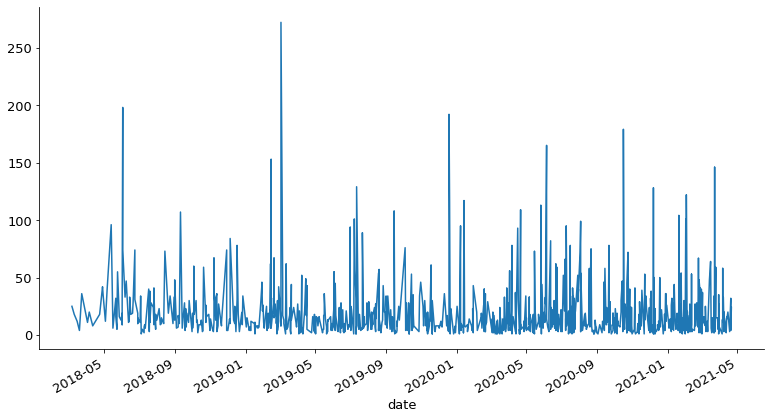

In [77]:
anomalies.pages.plot()

In [79]:
anomalies.user_id.nunique()

413

In [80]:
df.user_id.nunique()

981